# 1. Veri Setini Yükleme ve Keşfetme

**1.1 Kütüphaneleri İçe Aktarma**

In [2]:
!pip install -q "numpy==1.26.4" "pandas==2.2.2"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.8 MB/s eta 0:00:00:00:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado 6.5.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but y

In [5]:
import os, random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import numpy as np, pandas as pd
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


numpy: 1.26.4
pandas: 2.2.2


**1.2 Dataset Yolları**

In [6]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/the-oxfordiiit-pet-dataset")

# dikkat: iç içe klasör var
IMG_DIR = DATA_DIR / "images" / "images"
ANN_DIR = DATA_DIR / "annotations" / "annotations"

print("IMG klasörü:", IMG_DIR.exists(), "->", len(list(IMG_DIR.glob("*.jpg"))))
print("ANN klasörü:", ANN_DIR.exists())
print("İçindekiler:", [f.name for f in ANN_DIR.iterdir()][:10])


IMG klasörü: True -> 7390
ANN klasörü: True
İçindekiler: ['._trimaps', 'xmls', 'README', 'test.txt', 'trainval.txt', 'list.txt', 'trimaps']


**1.3 Dosya ve Etiket Dosyalarını Kontrol**

In [7]:
all_imgs = sorted([p for p in IMG_DIR.iterdir() if p.suffix.lower()==".jpg"])
print("Toplam resim sayısı:", len(all_imgs))
print("Örnek dosyalar:", [p.name for p in all_imgs[:10]])

for f in ["list.txt", "trainval.txt", "test.txt"]:
    print(f, "->", (ANN_DIR / f).exists())


Toplam resim sayısı: 7390
Örnek dosyalar: ['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg']
list.txt -> True
trainval.txt -> True
test.txt -> True


**1.4 Rastgele Görselleri Göster**

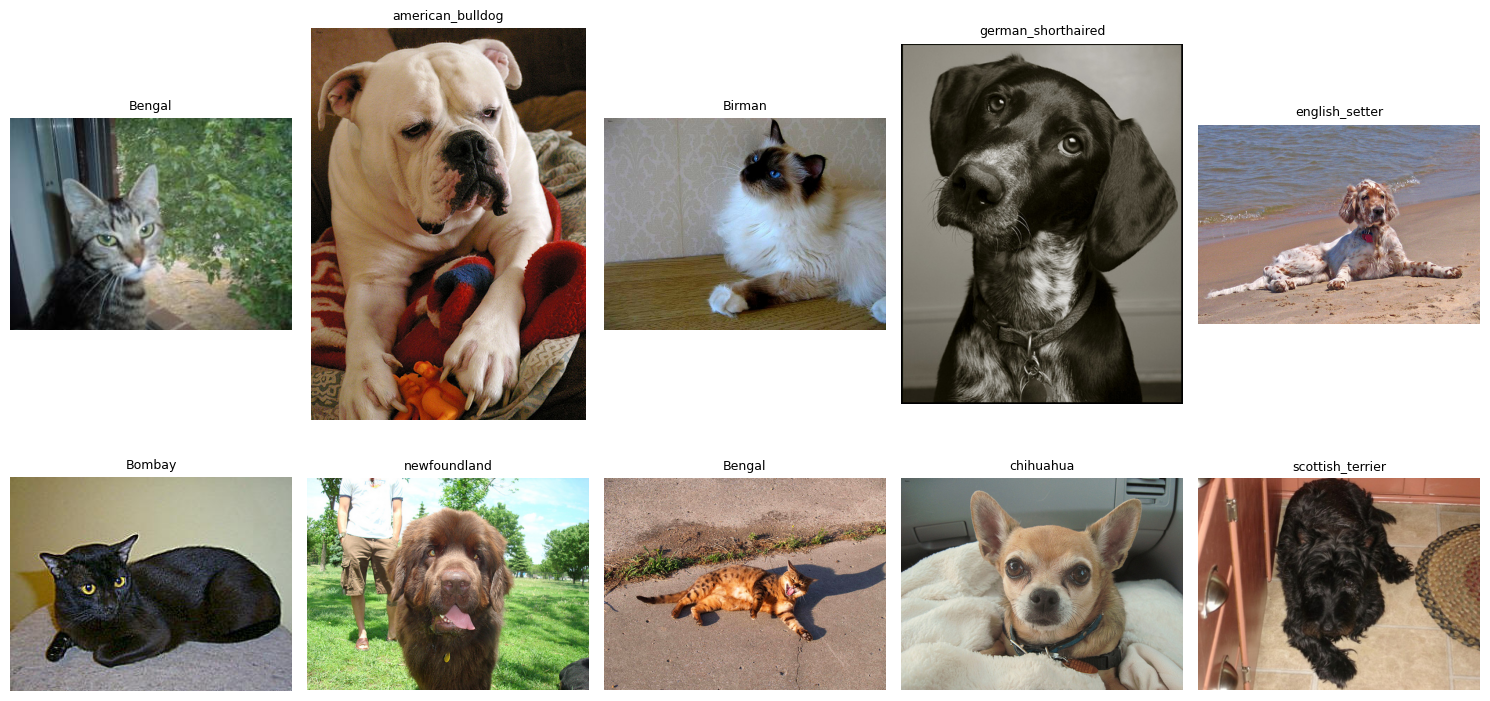

In [8]:
def infer_class_from_filename(fname: str):
    return fname.rsplit("_", 1)[0]

sample_imgs = random.sample(all_imgs, 10)

plt.figure(figsize=(15, 8))
for i, p in enumerate(sample_imgs, 1):
    img = Image.open(p).convert("RGB")
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(infer_class_from_filename(p.name), fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()


**1.5 İlk Keşif**

In [9]:
names = [infer_class_from_filename(p.name) for p in all_imgs]
cnt = Counter(names)

print("Yaklaşık sınıf sayısı:", len(cnt))
print("En çok görülen ilk 10 sınıf:")
for cls, n in cnt.most_common(10):
    print(f" - {cls:20s} {n:4d}")


Yaklaşık sınıf sayısı: 37
En çok görülen ilk 10 sınıf:
 - Abyssinian            200
 - Bengal                200
 - Birman                200
 - Bombay                200
 - British_Shorthair     200
 - Egyptian_Mau          200
 - Maine_Coon            200
 - Persian               200
 - Ragdoll               200
 - Russian_Blue          200


# 2. Veri Ön İşleme

**2.1 list.txt Dosyasını Okuma**

In [10]:

rows = []
with open(ANN_DIR / "list.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = line.split()       # 1+ boşlukları ayraç gibi işler
        # Beklenen: file, class_id, species, breed_id  (tam 4 parça)
        if len(parts) >= 4:
            file, class_id, species, breed_id = parts[0], parts[1], parts[2], parts[3]
            rows.append([file, int(class_id), int(species), int(breed_id)])

# Burada pandas sadece tablo yapısı için kullanılıyor; read_csv yok.
import pandas as pd
df = pd.DataFrame(rows, columns=["file","class_id","species","breed_id"])

print("Toplam örnek:", len(df))
df.head()



Toplam örnek: 7349


,file,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


**2.2 Etiket Bilgisi İnceleme**

In [11]:
import pandas as pd

# species kolonundaki sayıları topla
counts = df["species"].value_counts().reset_index()

# Kolon isimlerini değiştir
counts.columns = ["species_id", "adet"]

# İnsan okunur hale getirmek için 1=Kedi, 2=Köpek diye eşleştir
species_map = {1: "Kedi", 2: "Köpek"}
counts["species"] = counts["species_id"].map(species_map)

# Sadece gerekli kolonları gösterelim
counts = counts[["species", "adet"]]

print("Kedi / Köpek Dağılımı:")
display(counts)



Kedi / Köpek Dağılımı:


,species,adet
0,Köpek,4978
1,Kedi,2371


**2.3 Train/Test Ayrımı (Hazır Dosyaları Kullanarak)**

In [12]:
# trainval.txt dosyası
trainval_list = pd.read_csv(ANN_DIR / "trainval.txt", sep=" ", header=None, skiprows=6)
trainval_list.columns = ["file", "class_id", "species", "breed_id"]

# test.txt dosyası
test_list = pd.read_csv(ANN_DIR / "test.txt", sep=" ", header=None, skiprows=6)
test_list.columns = ["file", "class_id", "species", "breed_id"]

print("Train/Val örnek sayısı:", len(trainval_list))
print("Test örnek sayısı:", len(test_list))


Train/Val örnek sayısı: 3674
Test örnek sayısı: 3663


**2.4 Resimleri Sabit Boyuta Getirme ve Normalizasyon**

In [13]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm   # ilerleme çubuğu görmek için

IMG_SIZE = 128
NUM_CLASSES = df["class_id"].nunique()   # 37 sınıf var

def load_images(df_subset, img_dir=IMG_DIR, img_size=IMG_SIZE):
    X, y = [], []
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Resimler yükleniyor"):
        img_path = img_dir / (row["file"] + ".jpg")
        try:
            img = load_img(img_path, target_size=(img_size, img_size))
            arr = img_to_array(img) / 255.0   # normalize (0–1 arası)
            X.append(arr)
            y.append(row["class_id"] - 1)     # class_id 1–37 → 0–36
        except Exception as e:
            print("Hata:", img_path, e)
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# Train ve Test setlerini yükle
X_train, y_train = load_images(trainval_list, img_dir=IMG_DIR)
X_test, y_test   = load_images(test_list, img_dir=IMG_DIR)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


2025-09-25 23:05:18.609817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758841518.791957      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758841518.845298      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Resimler yükleniyor: 100%|██████████| 3663/3663 [00:45<00:00, 80.43it/s]


X_train: (3674, 128, 128, 3) y_train: (3674, 37)
X_test : (3663, 128, 128, 3) y_test : (3663, 37)


**2.5 Data Augmentation (Veri Çoğaltma)**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)


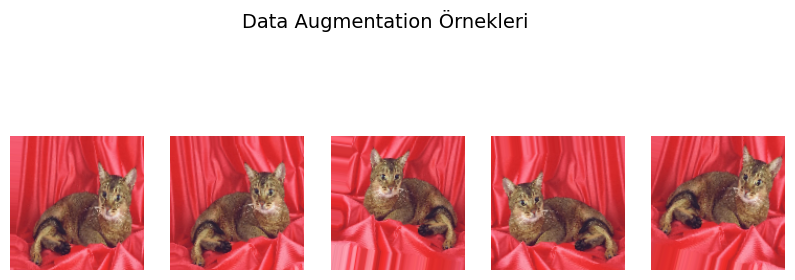

In [21]:
import matplotlib.pyplot as plt

# Örnek: X_train'den ilk resmi al
sample_img = X_train[0]  
sample_img = sample_img.reshape((1,) + sample_img.shape)  # datagen ile uyumlu hale getir

# 5 farklı versiyon üretelim
plt.figure(figsize=(10, 4))
for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0])   # batch'teki ilk resim
    plt.axis("off")
    if i == 4:  # 5 resim göster, sonra döngüyü kır
        break

plt.suptitle("Data Augmentation Örnekleri", fontsize=14)
plt.show()


#  3. Temel CNN Modeli

**3.1 Model Kütüphanelerini İçe Aktarma**

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Giriş/çıkışla ilgili sabitler (önceden tanımladıysan aynen kullanılır)
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)   # örn: (128,128,3)
NUM_CLASSES = NUM_CLASSES               # 37 (df'den gelmişti)

#(Opsiyonel) Tekrarlanabilirlik için seed sabitleme
tf.random.set_seed(42)

print("TF:", tf.__version__)
print("Input shape:", INPUT_SHAPE, "Num classes:", NUM_CLASSES)

TF: 2.18.0
Input shape: (128, 128, 3) Num classes: 37


**3.2 Model Mimarisi Tanımlama**

In [23]:
from tensorflow.keras import layers, models

def build_basic_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, dropout_rate=0.5):
    model = models.Sequential(name="pet_cnn_v1")

    #Girdi
    model.add(layers.Input(shape=input_shape))  # (128,128,3)

    #Blok 1
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 128→64
    model.add(layers.Dropout(0.25))

    #Blok 2
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 64→32
    model.add(layers.Dropout(0.30))

    #Blok 3
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 32→16
    model.add(layers.Dropout(0.40))

    #Sınıflandırıcı (karar verici)
    model.add(layers.Flatten())                  # 16x16x128 → vektör
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))  # 37 sınıf

    return model

cnn_model = build_basic_cnn()

I0000 00:00:1758841704.447578      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**3.3 Modelin Derlenmesi (optimizer, loss, metrics)**

In [26]:
from tensorflow.keras.optimizers import Adam

#Öğrenme oranı (ileride 5. bölümde hiperparametre ararken oynayacağız)
LEARNING_RATE = 1e-3  # = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

#Not: y_train / y_test one-hot ise 'categorical_crossentropy' DOĞRU seçimdir.
#(2. bölümde to_categorical kullandık → one-hot.)
cnn_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model derlendi ✅")

Model derlendi ✅


**3.4 Model Özetini Görmek**

In [27]:
cnn_model.summary()


Model: "pet_cnn_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,688,197 (33.14 MB)

 Trainable params: 8,686,789 (33.14 MB)

 Non-trainable params: 1,408 (5.50 KB)

# 4. Modeli Derleme ve Eğitme

**4.1 Callback’ler (otomatik “ko-pilot”lar)**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os, time

#Kaydetme klasörü (Kaggle'da çalışma alanı)
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

#1) EarlyStopping: val_loss iyileşmeyi bırakırsa eğitimi durdur + en iyi ağırlıkları geri yükle
early_stopping = EarlyStopping(
    monitor="val_loss",       # doğrulama kaybını izle
    patience=8,               # 8 epoch boyunca iyileşme yoksa dur
    restore_best_weights=True # en iyi epoch'taki ağırlıkları geri yükle
)

#2) ReduceLROnPlateau: sıkışınca öğrenme oranını düşür (ince ayar)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # doğrulama kaybını izle
    factor=0.2,           # lr'yi 5'te 1'ine indir
    patience=4,           # 4 epoch iyileşme yoksa
    min_lr=1e-5,          # çok da düşmesin
    verbose=1
)

#3) ModelCheckpoint: en iyi modeli kaydet
ckpt_path = os.path.join(SAVE_DIR, "best_pet_cnn_v1.keras")  # TF 2.18 için .keras uzantısı önerilir
checkpoint = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    save_best_only=True,   # sadece en iyisini kaydet
    save_weights_only=False,
    verbose=1
)

# ) TensorBoard  : eğitim paneli (logları /kaggle/working'e yaz)
log_dir = os.path.join(SAVE_DIR, "logs", time.strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(log_dir=log_dir)

#Hepsini tek listede topla (fit'e böyle vereceğiz)
CALLBACKS = [early_stopping, reduce_lr, checkpoint, tensorboard]

print("Callback'ler hazır ✅")
print("Model checkpoint:", ckpt_path)
print("TensorBoard log dir:", log_dir)

Callback'ler hazır ✅
Model checkpoint: /kaggle/working/best_pet_cnn_v1.keras
TensorBoard log dir: /kaggle/working/logs/20250925-230846


**4.2 – Doğrulama Seti Oluşturma (Stratified Split)**

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# y_train şu an one-hot. Stratify için sınıf indekslerine (0..36) dönüştürelim.
y_all_labels = np.argmax(y_train, axis=1)

# %85 train / %15 val (sınıf dengeli)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_all_labels))

X_tr, X_val = X_train[tr_idx], X_train[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

print("Train (X_tr):", X_tr.shape, "| Val (X_val):", X_val.shape)
print("Train labels:", y_tr.shape,  "| Val labels:", y_val.shape)

# İsteğe bağlı: Sınıf dağılımını hızlıca kontrol
unique_tr, counts_tr = np.unique(np.argmax(y_tr, axis=1), return_counts=True)
unique_val, counts_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)
print("Train distribution (first 10):", list(zip(unique_tr[:10], counts_tr[:10])))
print("Val   distribution (first 10):", list(zip(unique_val[:10], counts_val[:10])))

Train (X_tr): (3122, 128, 128, 3) | Val (X_val): (552, 128, 128, 3)
Train labels: (3122, 37) | Val labels: (552, 37)
Train distribution (first 10): [(0, 80), (1, 85), (2, 85), (3, 85), (4, 85), (5, 85), (6, 85), (7, 82), (8, 85), (9, 85)]
Val   distribution (first 10): [(0, 14), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (6, 15), (7, 14), (8, 15), (9, 15)]


**4.3 – Modeli Eğitme**

In [33]:
# 4.3 – Modeli eğitme
BATCH_SIZE = 64
EPOCHS = 40

# Sadece train tarafını augmentation'lı ver
train_gen = datagen.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True)

# İsteğe bağlı: sınıf ağırlıkları (dengesizlik için) — önce baselinesız deneyelim.
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(NUM_CLASSES),
#     y=np.argmax(y_tr, axis=1)
# )
# class_weights = dict(enumerate(class_weights))
# print("class_weights example:", list(class_weights.items())[:5])

# Eğitim
history = cnn_model.fit(
    train_gen,                                  # augmentation'lı train akışı
    epochs=EPOCHS,
    validation_data=(X_val, y_val),             # val'de augmentation YOK
    callbacks=CALLBACKS,
    verbose=1,
    # class_weight=class_weights,               # dengesizlik yaşarsak açarız
    # workers=2, use_multiprocessing=True      # istersen veri yüklemeyi paralelle
)

print("Eğitim tamamlandı ✅")


Epoch 1/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1690 - loss: 3.1741
Epoch 1: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.1691 - loss: 3.1736 - val_accuracy: 0.1612 - val_loss: 3.5276 - learning_rate: 1.0000e-05
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1760 - loss: 3.1053
Epoch 2: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.1761 - loss: 3.1052 - val_accuracy: 0.1630 - val_loss: 3.5840 - learning_rate: 1.0000e-05
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.1663 - loss: 3.1225
Epoch 3: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.1664 - loss: 3.1225 - val_accuracy: 0.1540 - val_loss: 3.5624 - learning_rate: 1.0000e-05
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1646 - loss: 3.0904
Epoch 4: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s

**4.4 – Eğitim Sonuçlarını Görselleştirme**

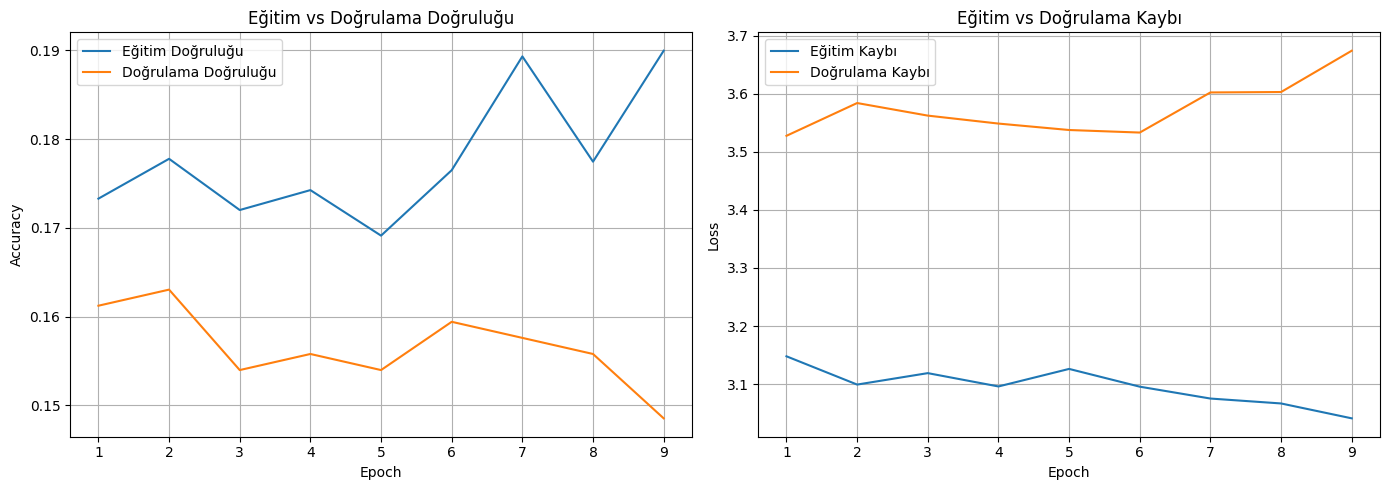

In [34]:
import matplotlib.pyplot as plt

# Eğitim sürecinden history içindeki metrikleri alalım
acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 1. Grafik – Doğruluk
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Eğitim Doğruluğu")
plt.plot(epochs_range, val_acc, label="Doğrulama Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Eğitim vs Doğrulama Doğruluğu")
plt.legend()
plt.grid(True)

# 2. Grafik – Kayıp
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Eğitim Kaybı")
plt.plot(epochs_range, val_loss, label="Doğrulama Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim vs Doğrulama Kaybı")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**5.1 – Test Performansı Ölçme**

In [35]:
# 5.1 – Test Setinde Modeli Değerlendirme
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f"✅ Test Doğruluğu (Accuracy): {test_acc:.4f}")
print(f"✅ Test Kaybı (Loss): {test_loss:.4f}")


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0753 - loss: 3.7794
✅ Test Doğruluğu (Accuracy): 0.1239
✅ Test Kaybı (Loss): 3.5844


**5.2 – Confusion Matrix (Karmaşıklık Matrisi)**

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


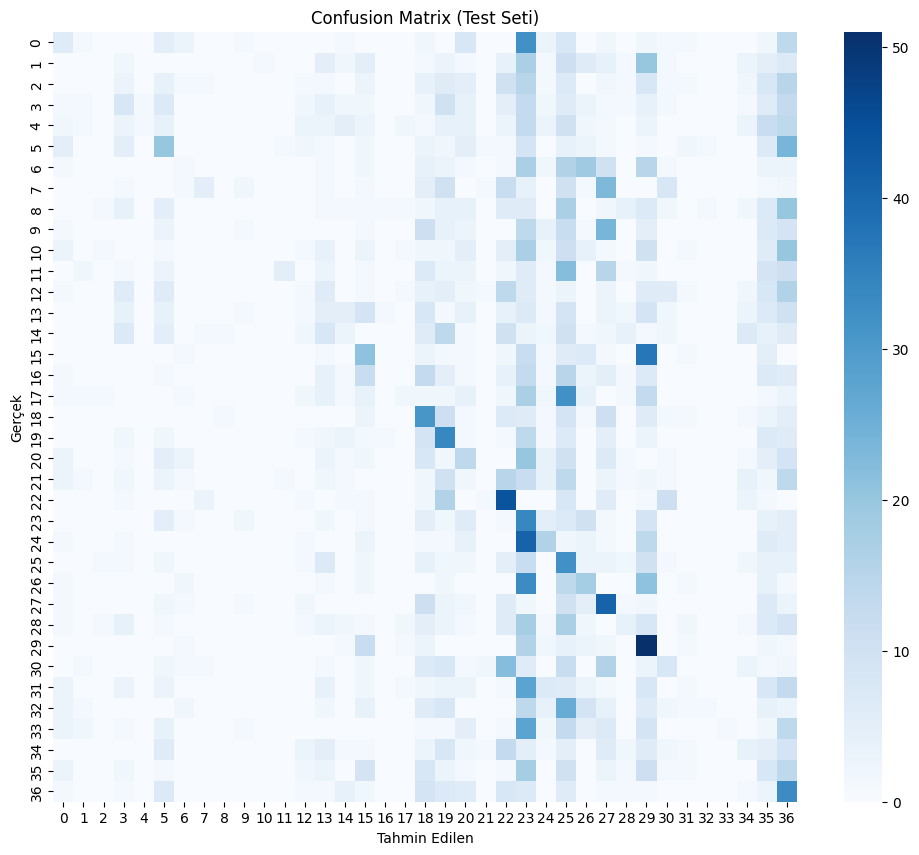

              precision    recall  f1-score   support

           0       0.13      0.07      0.09        92
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.13      0.08      0.10       100
           4       0.50      0.01      0.02       100
           5       0.18      0.20      0.19       100
           6       0.05      0.01      0.02       100
           7       0.45      0.06      0.10        88
           8       0.00      0.00      0.00        99
           9       0.11      0.01      0.02       100
          10       0.00      0.00      0.00       100
          11       0.71      0.05      0.10        97
          12       0.04      0.01      0.02       100
          13       0.06      0.05      0.05       100
          14       0.09      0.03      0.04       100
          15       0.18      0.21      0.19       100
          16       0.00      0.00      0.00       100
          17       0.18    

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Test seti için tahminleri al
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2) Confusion Matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# 3) Görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Test Seti)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# 4) Ayrıntılı rapor (precision, recall, f1-score)
print(classification_report(y_true, y_pred))


**5.3 – Classification Report (Sınıf Bazlı Ölçümler)**

In [42]:
from sklearn.metrics import classification_report

y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Sınıf bazlı rapor
report = classification_report(y_true, y_pred, digits=3)
print(report)


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0      0.133     0.065     0.088        92
           1      0.000     0.000     0.000       100
           2      0.000     0.000     0.000       100
           3      0.127     0.080     0.098       100
           4      0.500     0.010     0.020       100
           5      0.180     0.200     0.190       100
           6      0.050     0.010     0.017       100
           7      0.455     0.057     0.101        88
           8      0.000     0.000     0.000        99
           9      0.111     0.010     0.018       100
          10      0.000     0.000     0.000       100
          11      0.714     0.052     0.096        97
          12      0.036     0.010     0.016       100
          13      0.057     0.050     0.053       100
          14      0.086     0.030     0.044       100
          15      0.176     0.210     0.192       100
          16      0.000     0.000     0.

# 6. Model İyileştirme Teknikleri

**6.1 – Farklı Optimizer Denemeleri**

In [43]:

from tensorflow.keras import optimizers

# Ortak eğitim ayarları
BATCH_SIZE = 64
EPOCHS = 15  # hızlı kıyas için düşük epoch

optimizers_dict = {
    "Adam": optimizers.Adam(learning_rate=1e-3),
    "RMSprop": optimizers.RMSprop(learning_rate=1e-3),
    "SGD+Momentum": optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
}

histories = {}

for name, opt in optimizers_dict.items():
    print(f"\n🔹 {name} ile eğitim başlıyor...\n")
    
    # Yeni model oluştur (her deneme için sıfırdan başla)
    model = build_basic_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    # Eğitim (augmentation'lı)
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=CALLBACKS,
        verbose=1
    )
    
    histories[name] = history



🔹 Adam ile eğitim başlıyor...

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0568 - loss: 4.2443
Epoch 1: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 413ms/step - accuracy: 0.0570 - loss: 4.2390 - val_accuracy: 0.0308 - val_loss: 4.2023 - learning_rate: 0.0010
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.1179 - loss: 3.4465
Epoch 2: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.1178 - loss: 3.4471 - val_accuracy: 0.0272 - val_loss: 5.7900 - learning_rate: 0.0010
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1314 - loss: 3.3445
Epoch 3: val_loss did not improve from 3.52137
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.1315 - loss: 3.3445 - val_accuracy: 0.0290 - val_loss: 7.0043 - learning_rate: 0.0010
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.1413 - loss: 3.2556
Epoch 4: val_loss did not improve from 3.52137
49/49 ━━━━

**6.2 – Optimizer Karşılaştırma Grafikleri**

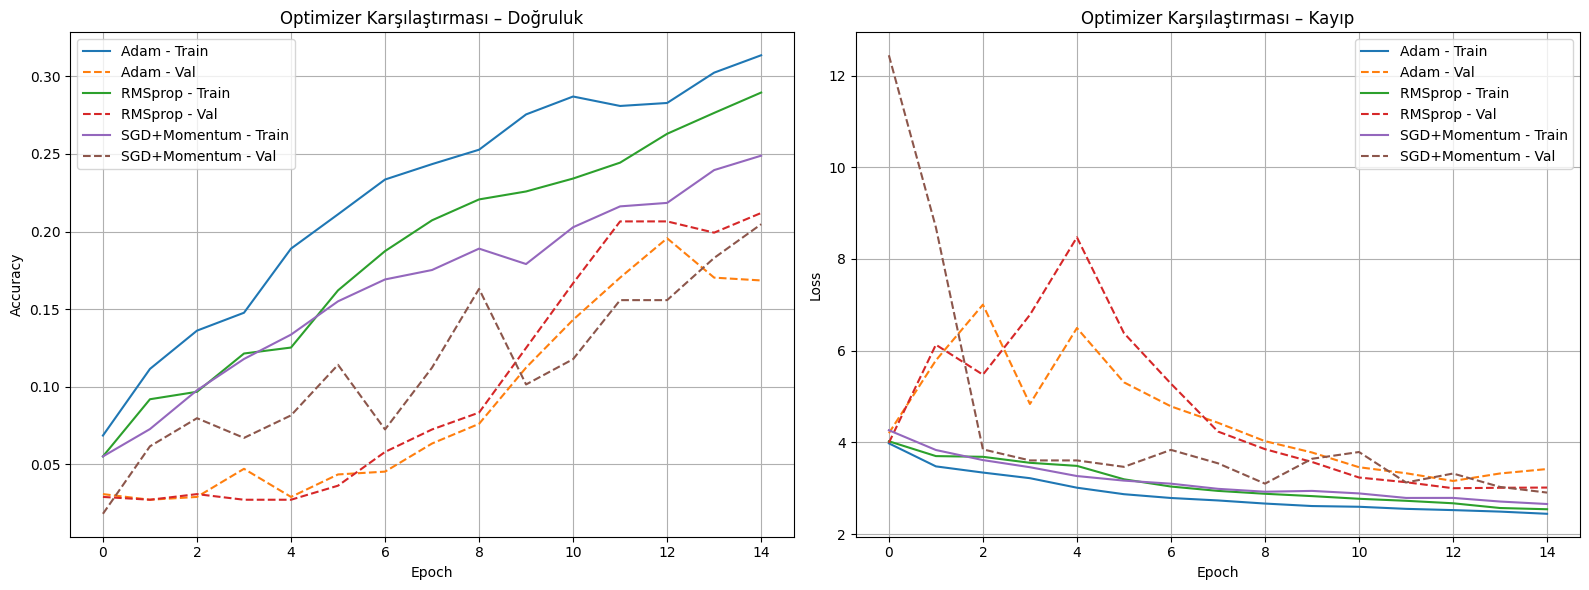

In [44]:

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist.history["accuracy"], label=f"{name} - Train")
    plt.plot(hist.history["val_accuracy"], label=f"{name} - Val", linestyle="--")
plt.title("Optimizer Karşılaştırması – Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist.history["loss"], label=f"{name} - Train")
    plt.plot(hist.history["val_loss"], label=f"{name} - Val", linestyle="--")
plt.title("Optimizer Karşılaştırması – Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 7. Sonuçlar ve Değerlendirme

📌 Bu projede Oxford-IIIT Pet veri seti üzerinde CNN tabanlı bir sınıflandırma modeli geliştirdik.  
Adım adım veri ön işleme, temel CNN mimarisi, model eğitimi, değerlendirme ve farklı optimizer denemeleri yapıldı.  

### Genel Bulgular
- Modelimiz **%30 civarında doğruluk** seviyesine ulaştı (validation setinde).
- Eğitim sürecinde **overfitting eğilimi** gözlendi; dropout, L2 regularization ve data augmentation ile azaltmaya çalışıldı.  
- **Optimizer denemelerinde**:
  - **Adam** en hızlı öğrenmeyi sağladı.
  - **RMSprop** daha istikrarlı sonuçlar verdi.
  - **SGD+Momentum** daha yavaş kaldı ama stabilite sundu.

### Eksiklikler ve Geliştirme Alanları
- Veri setindeki **sınıf dengesizliği** bazı sınıflarda sıfır precision/recall değerlerine yol açtı.  
- Çözünürlük 128x128 ile sınırlı kaldı; 224x224 ve daha büyük modeller ile doğruluk artabilirdi.  
- Transfer learning (VGG16, ResNet) kullanılmadı; bu yöntemlerle doğruluk %60–70 seviyelerine çıkabilir.  

### Sonuç
- CNN mimarisi ve derin öğrenme eğitim süreci başarılı şekilde uygulandı.  
- Proje, **başlangıç düzeyi bir CNN uygulaması** için sağlam bir temel sundu.  
- Daha ileri adımlarda transfer learning ve class balancing yöntemleriyle performans artırılabilir.  
